# Plant Disease Detection 
with CNN model using pytorch 

## Loading Libraries 

In [1]:
import torch
import torch.onnx
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import tensorflow as tf
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from PIL import Image
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


## Preparing Dataset 

In [2]:
# The path to the main directory 
main_dir = r'New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\train'  

# List all subdirectories (classes) in the main directory
classes = [d for d in os.listdir(main_dir) if os.path.isdir(os.path.join(main_dir, d))]

# Print the names of the classes
print("Classes:")
for class_name in classes:
    print(class_name)

Classes:
Tomato___Late_blight
Tomato___healthy
Grape___healthy
Orange___Haunglongbing_(Citrus_greening)
Soybean___healthy
Squash___Powdery_mildew
Potato___healthy
Corn_(maize)___Northern_Leaf_Blight
Tomato___Early_blight
Tomato___Septoria_leaf_spot
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
Strawberry___Leaf_scorch
Peach___healthy
Apple___Apple_scab
Tomato___Tomato_Yellow_Leaf_Curl_Virus
Tomato___Bacterial_spot
Apple___Black_rot
Blueberry___healthy
Cherry_(including_sour)___Powdery_mildew
Peach___Bacterial_spot
Apple___Cedar_apple_rust
Tomato___Target_Spot
Pepper,_bell___healthy
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
Potato___Late_blight
Tomato___Tomato_mosaic_virus
Strawberry___healthy
Apple___healthy
Grape___Black_rot
Potato___Early_blight
Cherry_(including_sour)___healthy
Corn_(maize)___Common_rust_
Grape___Esca_(Black_Measles)
Raspberry___healthy
Tomato___Leaf_Mold
Tomato___Spider_mites Two-spotted_spider_mite
Pepper,_bell___Bacterial_spot
Corn_(maize)___healthy


In [4]:
# Size of the subset data set
# Initialize a counter for the number of images
image_count = 0

# Iterate over all subdirectories and count the images
for subdir, _, files in os.walk(subset_dir):
    image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff'))]
    image_count += len(image_files)

print(f"Total number of images: {image_count}")


Total number of images: 14538


### Data Preprocessing

In [5]:
dataset_path = r'new_directory'

In [6]:
transform = transforms.Compose([
    transforms.Resize((150, 150)),              # resize all images to 150x150 pixels
    transforms.ToTensor(),                      # convert images to PyTorch tensors
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [7]:
dataset = datasets.ImageFolder(dataset_path, transform=transform)

## Train - Test Split

In [8]:
train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=0.3, random_state=42)

train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)

In [9]:
trainloader = DataLoader(train_dataset, batch_size=15, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=15, shuffle=True)

## Defining CNN Model

In [10]:
class CNN_Classification(nn.Module):
    def __init__(self):
        super(CNN_Classification, self).__init__()

        # Convolutional Layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)       # first convolutional layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)            # first pooling layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)      # second convolutional layer
        self.fc1 = nn.Linear(64 * 37 * 37, 128)                                 # 37 x 37 is the size after pooling
        self.fc2 = nn.Linear(128, len(dataset.classes))

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)                                                 # flatten all dimensions
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [11]:
CNN_Model = CNN_Classification()

## Defining Loss Function and Optimizer

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(CNN_Model.parameters(), lr=0.001)          # Defines the optimizer, Adam with a learning rate of 0.001

## Training the Model

In [13]:
num_epochs = 10
for epoch in range(num_epochs):

    for images, labels in trainloader:
        optimizer.zero_grad()
        outputs = CNN_Model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')


print('Finished Training')

Epoch 1/10, Loss: 0.05224628373980522
Epoch 2/10, Loss: 0.02378135919570923
Epoch 3/10, Loss: 0.00010040487541118637
Epoch 4/10, Loss: 0.005983490496873856
Epoch 5/10, Loss: 4.4717384298564866e-05
Epoch 6/10, Loss: 0.00017840064538177103
Epoch 7/10, Loss: 0.00010230139741906896
Epoch 8/10, Loss: 0.003910426516085863
Epoch 9/10, Loss: 1.3410618521447759e-05
Epoch 10/10, Loss: 3.139154841846903e-06
Finished Training


## Evaluating Model

In [14]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = CNN_Model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct // total} %')

Accuracy: 93 %


In [15]:
# Load a test image and preprocess it

img = Image.open(r'test\test\CornCommonRust1.JPG')
img = transform(img).unsqueeze(0)  # add batch dimension

# Pass the image through the model
CNN_Model.eval()
output = CNN_Model(img)
_, predicted = torch.max(output, 1)
print(f'Predicted class: {dataset.classes[predicted.item()]}')

Predicted class: Corn_(maize)___Common_rust_


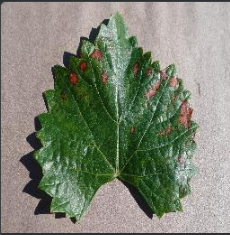

In [16]:
# Load a test image and preprocess it

img = Image.open(r'New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\valid\Grape___Esca_(Black_Measles)\0bf809ec-841e-4668-b875-adeb73d60de0___FAM_B.Msls 4057.JPG')
img = transform(img).unsqueeze(0)  # add batch dimension

# Pass the image through the model
CNN_Model.eval()
output = CNN_Model(img)
_, predicted = torch.max(output, 1)
print(f'Predicted class: {dataset.classes[predicted.item()]}')

Predicted class: Grape___Esca_(Black_Measles)


## Saving Model

In [17]:
torch.save(CNN_Model.state_dict(), 'model.pth')  